# AllCTs

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Importing libraries

In [2]:
import os
import glob
import json

import torch
from torch.utils.data import Dataset
import torchio as tio

from tqdm import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nrrd
from scipy.ndimage import binary_fill_holes
from dataset import utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Getting data paths

In [8]:
input_folder = '../data/AllCTs/'
output_folder = '../data/AllCTs_nrrd_global/'
folder_names = [folder_name for folder_name in os.listdir(input_folder) if '.' not in folder_name]
folder_path = [os.path.join(input_folder, folder_name) for folder_name in folder_names]
folder_c_path = [os.path.join(folder_path[idx], f'{folder_name}_C.stl') for idx, folder_name in enumerate(folder_names)]
folder_m_path = [os.path.join(folder_path[idx], f'{folder_name}_M.stl') for idx, folder_name in enumerate(folder_names)]
zipped_path = list(zip(folder_c_path, folder_m_path))


## Analyzing statistics

### Calculating bounds

In [ ]:
bounds = []
for idx, (c_path, m_path) in enumerate(zipped_path):
    print(f'Processing {idx+1}/{len(zipped_path)}')
    if os.path.exists(c_path) and os.path.exists(m_path):
        # Load meshes
        mesh_c = o3d.io.read_triangle_mesh(c_path)
        mesh_m = o3d.io.read_triangle_mesh(m_path)
        
        # Merge meshes
        merged_mesh = mesh_c + mesh_m

        # Create a scene and add the triangle mesh
        scene_mesh = o3d.t.geometry.TriangleMesh.from_legacy(merged_mesh)
        scene = o3d.t.geometry.RaycastingScene()
        _ = scene.add_triangles(scene_mesh)  # we do not need the geometry ID for mesh

        # Get the bounding box of the scene
        min_bound = scene_mesh.vertex.positions.min(0).numpy()
        max_bound = scene_mesh.vertex.positions.max(0).numpy()
        bounds.append((min_bound, max_bound))

Processing 1/946
Processing 2/946
Processing 3/946
Processing 4/946
Processing 5/946
Processing 6/946
Processing 7/946
Processing 8/946
Processing 9/946
Processing 10/946
Processing 11/946
Processing 12/946
Processing 13/946
Processing 14/946
Processing 15/946
Processing 16/946
Processing 17/946
Processing 18/946
Processing 19/946
Processing 20/946
Processing 21/946
Processing 22/946
Processing 23/946
Processing 24/946
Processing 25/946
Processing 26/946
Processing 27/946
Processing 28/946
Processing 29/946
Processing 30/946
Processing 31/946
Processing 32/946
Processing 33/946
Processing 34/946
Processing 35/946
Processing 36/946
Processing 37/946
Processing 38/946
Processing 39/946
Processing 40/946
Processing 41/946
Processing 42/946
Processing 43/946
Processing 44/946
Processing 45/946
Processing 46/946
Processing 47/946
Processing 48/946
Processing 49/946
Processing 50/946
Processing 51/946
Processing 52/946
Processing 53/946
Processing 54/946
Processing 55/946
Processing 56/946
P

In [17]:
bounds_array = np.array(bounds)
# Save the array to a file
np.save('../data/AllCTs/bounds_array.npy', bounds_array)

### Calculating global bounds

In [3]:
bounds_array = np.load('../data/AllCTs/bounds_array.npy')

In [4]:
# Get the minimum of the minimum bounds and the maximum of the maximum bounds
global_min_bound = np.amin(bounds_array[:, 0, :], axis=0)
global_max_bound = np.amax(bounds_array[:, 1, :], axis=0)

# The biggest bounding box
biggest_bbox = np.array([global_min_bound, global_max_bound])

print('Biggest bounding box:', biggest_bbox)

Biggest bounding box: [[ -86.90451 -117.31971  -98.27915]
 [  84.40348  119.54489  157.4383 ]]


In [5]:
axes_length = (global_max_bound - global_min_bound)
axes_length

array([171.30798, 236.8646 , 255.71744], dtype=float32)

In [6]:
spacing = 0.51
l_box = spacing*512
l_box, l_box > axes_length

(261.12, array([ True,  True,  True]))

In [7]:
axes_padding_space = l_box - axes_length
axes_padding_space

array([89.81201  , 24.255402 ,  5.4025574], dtype=float32)

In [39]:
padded_global_min_bound = global_min_bound - axes_padding_space/2
padded_global_max_bound = global_max_bound + axes_padding_space/2
padded_global_min_bound, padded_global_max_bound, padded_global_max_bound - padded_global_min_bound

(array([-131.81052, -129.44742, -100.98043], dtype=float32),
 array([129.30948, 131.67259, 160.13957], dtype=float32),
 array([261.12, 261.12, 261.12], dtype=float32))

In [63]:
((global_max_bound - global_min_bound)/512)

array([0.3345859 , 0.46262616, 0.49944812], dtype=float32)

## Test voxelization

In [128]:
c_path = '../data/AllCTs/CTS381/CTS381_C.stl'
m_path = '../data/AllCTs/CTS381/CTS381_M.stl'

mesh_c = o3d.io.read_triangle_mesh(c_path)
mesh_m = o3d.io.read_triangle_mesh(m_path)

# Merge meshes
merged_mesh = mesh_c + mesh_m

# Create a scene and add the triangle mesh
scene_mesh = o3d.t.geometry.TriangleMesh.from_legacy(merged_mesh)
scene = o3d.t.geometry.RaycastingScene()
_ = scene.add_triangles(scene_mesh)  # we do not need the geometry ID for mesh

xyz_range = np.linspace(padded_global_min_bound, padded_global_max_bound, num=64)

query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

occupancy = scene.compute_occupancy(query_points, nsamples=63)

# Save the occupancy grid
print('Writing to nrrd')
save_path = '../data/mesh-analysis-51mm/voxelization_test/CTS381.nrrd'
nrrd.write(save_path, occupancy.numpy())

Writing to nrrd


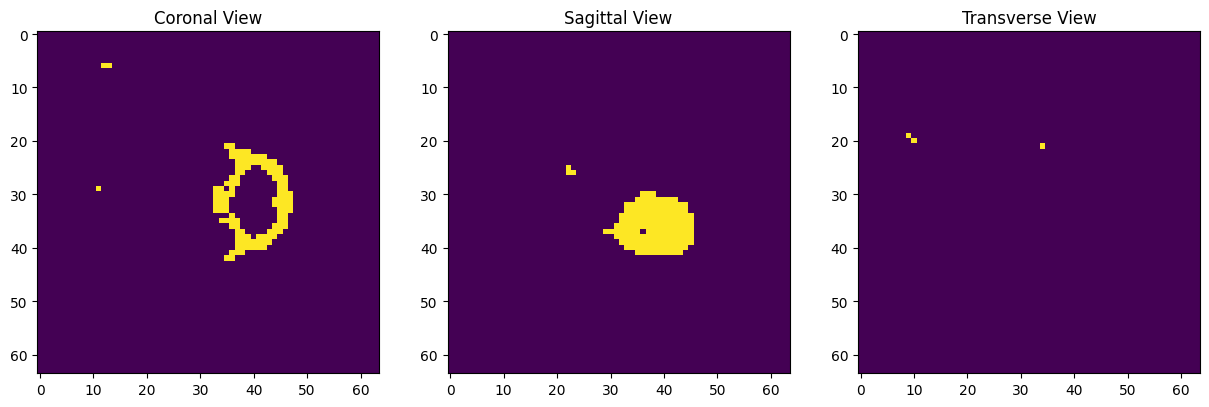

In [129]:
filepath = '../data/mesh-analysis-51mm/voxelization_test/CTS381.nrrd'
data, header = nrrd.read(filepath)

# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Coronal view (frontal plane)
axs[0].imshow(data[16, :, :])
axs[0].set_title('Coronal View')

# Sagittal view (saggital plane)
axs[1].imshow(data[:, 16, :])
axs[1].set_title('Sagittal View')

# Transverse view (horizontal plane)
axs[2].imshow(data[:, :, 16])
axs[2].set_title('Transverse View')

# Show the plot
plt.show()

In [126]:
actual_spacing = l_box/64
actual_spacing

4.08

In [127]:
utils.build_mesh(data, name='CTS381', output_folder='../data/mesh-analysis-51mm/voxelization_test/', spacing=[actual_spacing, actual_spacing, actual_spacing])

TriangleMesh with 12333 points and 24580 triangles.


## Voxelizing meshes

In [9]:
output_folder = '../data/AllCTs_nrrd_global/'
filled_ratios = []
file_start = 'CTS74'
start = False

In [ ]:
for idx, (c_path, m_path) in enumerate(zipped_path):
    if folder_names[idx] == file_start:
        start = True
        print('!!!!Starting!!!!')
    print(f'Processing {idx+1}/{len(zipped_path)}')
    print(folder_names[idx], c_path, m_path)
    if start and os.path.exists(c_path) and os.path.exists(m_path):
        # Load meshes
        mesh_c = o3d.io.read_triangle_mesh(c_path)
        mesh_m = o3d.io.read_triangle_mesh(m_path)
        
        # Merge meshes
        merged_mesh = mesh_c + mesh_m

        # Create a scene and add the triangle mesh
        scene_mesh = o3d.t.geometry.TriangleMesh.from_legacy(merged_mesh)
        scene = o3d.t.geometry.RaycastingScene()
        _ = scene.add_triangles(scene_mesh)  # we do not need the geometry ID for mesh
        
        xyz_range = np.linspace(global_min_bound, global_max_bound, num=512)
        query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

        occupancy = scene.compute_occupancy(query_points)

        # Save the occupancy grid
        print('Writing to nrrd')
        save_path = os.path.join(output_folder, f"{folder_names[idx]}.nrrd")
        nrrd.write(save_path, occupancy.numpy())

## Looking at some data

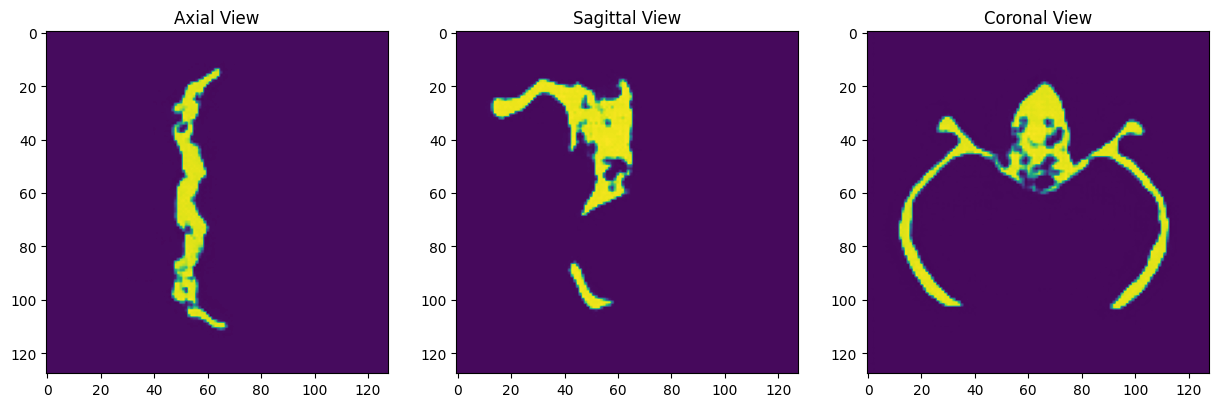

In [72]:
idx = 450

file_names = [file for file in os.listdir(output_folder) if file.endswith('.nrrd')]

file_names[idx] = 'ctg_44_q6.nrrd'
# Specify the path to the nrrd file
nrrd_file = os.path.join(output_folder, f'{file_names[idx]}')

# Read the nrrd file
data, header = nrrd.read(nrrd_file)

# Get the middle slice index
middle_slice = data.shape[0] // 2

# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axs[0].imshow(data[middle_slice, :, :])
axs[0].set_title('Axial View')

# Sagittal view
axs[1].imshow(data[:, middle_slice, :])
axs[1].set_title('Sagittal View')

# Coronal view
axs[2].imshow(data[:, :, middle_slice])
axs[2].set_title('Coronal View')

# Show the plot
plt.show()


## Rename files in folder to match name of splits

In [11]:
def rename_files(folder):
    # Get all .nrrd files in the folder
    files = glob.glob(os.path.join(
            folder, './**/*.nrrd'), recursive=True)

    for file in files:
        # Split the file path into folder, name and extension
        folder, name = os.path.split(file)
        base, ext = os.path.splitext(name)

        # Split the base into letters and number
        letters = base.rstrip('0123456789')
        number = base[len(letters):]

        # Rename the file
        new_name = '{}{:03}{}'.format(letters, int(number), ext)
        os.rename(file, os.path.join(folder, new_name))

In [12]:
rename_files(output_folder)

## Creating metadata.csv

In [63]:
raw_df = pd.read_csv('../data/allcts-global-128/metadata_raw.csv', sep=';')
# Remove where name is NaN
raw_df = raw_df[~raw_df['name'].isna()]
raw_df = raw_df[~raw_df['quality'].isna()]
raw_df

name quality   info
0    CTS000       5    NaN
1    CTS001       5    NaN
2    CTS002       5    NaN
3    CTS003       5    NaN
4    CTS004       3  short
..      ...     ...    ...
940   CT484       1    NaN
941   CT485       5    NaN
942   CT486       4    NaN
943   CT488       4    NaN
944   CT489       4    NaN

[944 rows x 3 columns]

Let's see how the quality score is distributed

In [65]:
raw_df['quality'].value_counts()

3       256
2       200
5       195
4       194
6        47
1        30
3.5       6
2.5       6
3,5       3
2,5       3
1.5       2
1.5       1
0         1
Name: quality, dtype: int64

As it is possible to see, there are some intermediate qualities that need to be fixed. To be conservative, I will XXX them to the lower integer.

In [66]:
quality_mapping = {
    '3.5': '3',
    '2.5': '2',
    '1.5': '1',
    '1.5 ': '1',
    '3,5': '3',
    '2,5': '2',
}

raw_df['quality'] = raw_df['quality'].replace(quality_mapping)
raw_df['quality'].value_counts()

3    265
2    209
5    195
4    194
6     47
1     33
0      1
Name: quality, dtype: int64

The first thing to do is to filter out CTs with score 1 or 0

In [67]:
filtered_df = raw_df[(raw_df['quality'] != '0') & (raw_df['quality'] != '1')]
print(filtered_df.shape)
filtered_df['quality'].value_counts()

(910, 3)


3    265
2    209
5    195
4    194
6     47
Name: quality, dtype: int64

Let's now explore the info values

In [68]:
filtered_df['info'].value_counts()

*           27
comp        12
* comp      11
part         8
*comp        8
cut ant      7
short        6
partial      3
v short      2
* short      2
*+           1
(bad)        1
*++          1
partial*     1
half         1
?            1
(*)          1
Name: info, dtype: int64

After analyzing the meaning of the labels we decided to remove some of these categories.

In [69]:
info_to_remove = ['(bad)']

filtered_df = filtered_df[~filtered_df['info'].isin(info_to_remove)]
filtered_df

name quality   info
0    CTS000       5    NaN
1    CTS001       5    NaN
2    CTS002       5    NaN
3    CTS003       5    NaN
4    CTS004       3  short
..      ...     ...    ...
937   CT480       3    NaN
941   CT485       5    NaN
942   CT486       4    NaN
943   CT488       4    NaN
944   CT489       4    NaN

[909 rows x 3 columns]

Now we have to divide the dataset in splits in a stratified fashion

In [73]:
# Split to train, val and test
# Stratify by quality
from sklearn.model_selection import train_test_split

train_df_index, val_test_df_index = train_test_split(filtered_df.index, test_size=0.2, stratify=filtered_df['quality'], random_state=42)

In [83]:
df = filtered_df.copy()
# Set the split column
df['split'] = 'train'
df['split'].loc[val_test_df_index] = 'test'
df

name quality   info  split
0    CTS000       5    NaN  train
1    CTS001       5    NaN  train
2    CTS002       5    NaN  train
3    CTS003       5    NaN  train
4    CTS004       3  short  train
..      ...     ...    ...    ...
937   CT480       3    NaN   test
941   CT485       5    NaN  train
942   CT486       4    NaN  train
943   CT488       4    NaN  train
944   CT489       4    NaN   test

[909 rows x 4 columns]

Now we have to rename the cts all to have leading zeros up to 3 decimals

In [96]:
def rename(row):
    name = row['name']
    base, ext = os.path.splitext(name)

    # Split the base into letters and number
    letters = base.rstrip('0123456789')
    number = base[len(letters):]

    # Rename the file
    new_name = '{}{:03}{}'.format(letters, int(number), ext)
    row['name'] = new_name
    return row
    

df = df.apply(rename, axis=1)


Let's check if all the files listed are present in the folder

In [100]:
def is_absent(row):
    name = row['name']
    file_name = os.path.join('../data/allcts-global-128/', name + '.nrrd')
    return not os.path.exists(file_name)

df.apply(is_absent, axis=1).sum()

0

Since all the files are present we can go on and save the metadata

In [101]:
# Save df to csv
df.to_csv('../data/allcts-global-128/metadata.csv', sep=',', index=False)

We will not integrate these files because they are qualitatively not good enough to be used for training

## Add filled ratio to df

In [36]:
# Function to compute the filled_ratio for a given name
def compute_filled_ratio(name):
    # Load the occupancy grid
    occupancy, _ = nrrd.read(os.path.join(output_folder, f"{name}.nrrd"))
    # Calculate the filled volume
    filled_volume = np.count_nonzero(occupancy)
    # Calculate and return the filled ratio
    return filled_volume / 134217728

0.06199205666780472

In [39]:
# Apply the function to the 'name' column and add the results as a new column
import multiprocessing as mp

# Create a pool of processes
with mp.Pool(mp.cpu_count()) as pool:
    # Apply the function to each row in parallel
    df['filled_ratio'] = pool.map(compute_filled_ratio, df['name'])

pool.close()
pool.join()

print(df)

In [11]:
output_path = os.path.join(output_folder, 'metadata.csv')
df.to_csv(output_path, index=False)


In [10]:
print(output_path)

../data/AllCTs_nrrd_global/metadata.csv


In [ ]:
ratios = [] # List of tuples (folder_name, qs, filled_ratio)
for idx, folder_name in enumerate(folder_names):
    print(f'Processing {idx+1}/{len(folder_names)}')
    if os.path.exists(os.path.join(output_folder, f"{folder_name}.nrrd")):
        # Load the occupancy grid
        occupancy, _ = nrrd.read(os.path.join(output_folder, f"{folder_name}.nrrd"))
        # Calculate the filled volume
        filled_volume = np.count_nonzero(occupancy)
        filled_ratio = filled_volume / 134217728
        ratios.append((folder_name, filled_ratio))


## Dataset inspection

In [7]:
df[df.name < 'CTS']

name  quality info  split
568  CT000        3  NaN  train
569  CT002        4  NaN   test
570  CT003        2  NaN  train
571  CT004        4  NaN  train
572  CT006        5  NaN  train
..     ...      ...  ...    ...
904  CT480        3  NaN   test
905  CT485        5  NaN  train
906  CT486        4  NaN  train
907  CT488        4  NaN  train
908  CT489        4  NaN   test

[341 rows x 4 columns]

<Figure size 3000x200 with 0 Axes>

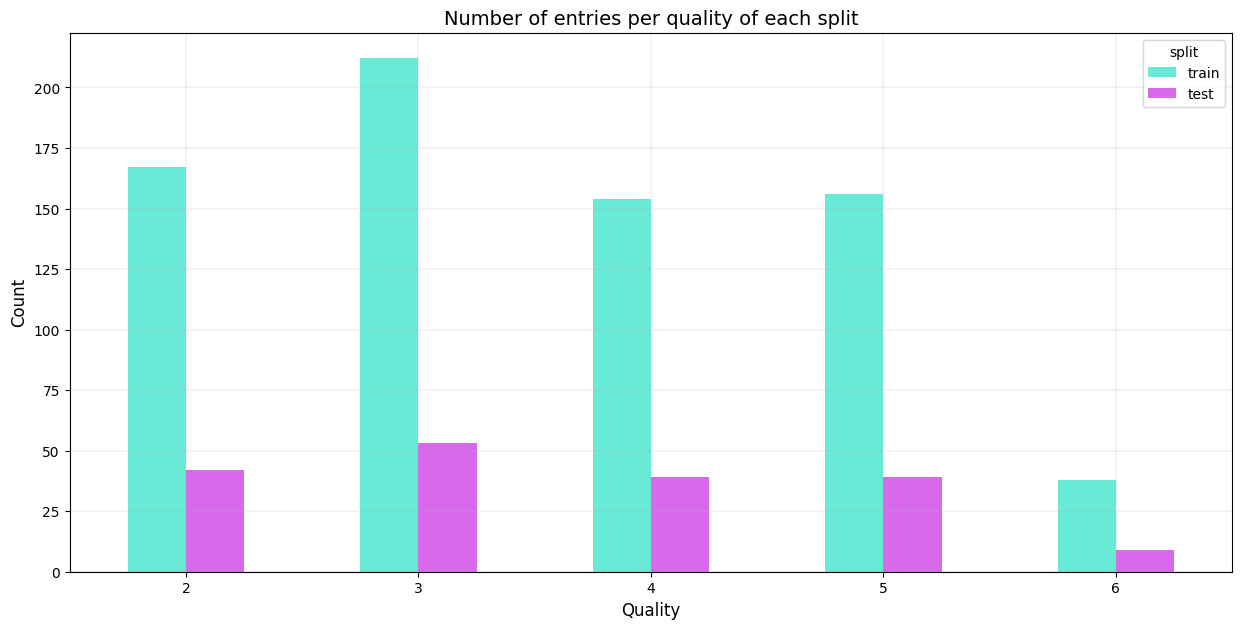

In [104]:
from IPython.core.pylabtools import figsize
figsize(15, 7)
# Set the figure size
plt.figure(figsize=(30, 2))

# Create the bar plot
quality_counts.plot(kind='bar', width=0.5, stacked=False, color=['#69ead7', '#d769ea', '#ead769'])

# Add gridlines
plt.grid(linewidth=0.2)

# Add title and labels
plt.title('Number of entries per quality of each split', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=0)

# Show the plot
plt.show()

## Creating qs metadata

In [8]:
name_dataset = 'filt-gen-05'

df = pd.read_csv(f'../data/{name_dataset}/metadata.csv')

# Count the number of entries per quality of each split
quality_counts = df.groupby(['quality', 'split']).size().unstack()
#quality_counts = quality_counts[['train', 'test']]
print(quality_counts)
print(quality_counts.sum())


split    train
quality       
2          167
3          212
4          154
5          156
6           38
split
train    727
dtype: int64


In [9]:
for i in range(5):
    df_quality = df.loc[df['quality'] == i+2]
    path = f'../data/{name_dataset}/metadata{i+2}.csv'
    df_quality.to_csv(path, index=False)
    print(f'Quality {i+2} saved to {path}')

Quality 2 saved to ../data/filt-gen-05/metadata2.csv
Quality 3 saved to ../data/filt-gen-05/metadata3.csv
Quality 4 saved to ../data/filt-gen-05/metadata4.csv
Quality 5 saved to ../data/filt-gen-05/metadata5.csv
Quality 6 saved to ../data/filt-gen-05/metadata6.csv


In [11]:
import wandb

# Provide your entity and a project name when you
# use wandb.Api methods.
api = wandb.Api(overrides={"project": "medicaldiffusion", "entity": "chavelanda"})

artifact_type, artifact_name = "model", 'model-l36ffu0v'  # provide type and name
for v in api.artifact_versions(artifact_type, artifact_name):
    # Clean up versions that don't have an alias such as 'latest'.
    # NOTE: You can put whatever deletion logic you want here.
    if len(v.aliases) == 0:
        v.delete()

## Testing dataset

In [3]:
from dataset import AllCTsDataset

In [28]:
dataset = AllCTsDataset(
    root_dir='../data/allcts-global-512-other-rot/',
    metadata_name='metadata.csv',
    split='train-val',
    binarize=True,
)

In [98]:
dataset2 = AllCTsDataset(
    root_dir='../data/allcts-gen-07/',
    metadata_name='metadata.csv',
    split='train-val',
    binarize=True,
)

In [30]:
img = dataset[0]['data']

In [31]:
128*128*128 - torch.sum(img == -1) - torch.sum(img == 1)

tensor(0)

In [5]:
dataset.df.iloc[73, :]

name         CT130
info           NaN
split        train
quality_2        0
quality_3        1
quality_4        0
quality_5        0
quality_6        0
Name: 662, dtype: object

In [142]:
dataset2.df.iloc[253, :]

name         allcts-gen-07-3_176
split                      train
quality_2                      0
quality_3                      1
quality_4                      0
quality_5                      0
quality_6                      0
Name: 343, dtype: object

# 51mm spacing dataset

In [23]:
dataset_folder = '../data/allcts-051-512-cube'

In [24]:
filenames = [file for file in os.listdir(dataset_folder) if file.endswith('.nrrd')]
filenames_w_e = [name[:-5] for name in filenames]
filenames_w_e[:10]

['CT000',
 'CT002',
 'CT003',
 'CT004',
 'CT006',
 'CT007',
 'CT009',
 'CT010',
 'CT011',
 'CT013']

In [5]:
df = pd.read_csv(os.path.join(dataset_folder, 'metadata.csv'))
df.head()

name  quality   info  split
0  CTS000        5    NaN  train
1  CTS001        5    NaN  train
2  CTS002        5    NaN  train
3  CTS003        5    NaN  train
4  CTS004        3  short  train

In [14]:
len(df.name), len(filenames_w_e)

(907, 945)

In [15]:
counter = 0
for name in sorted(set(filenames_w_e)):
    if name not in set(df.name):
        counter += 1
        # print(name)

counter

39

Visualizzo l'immagine per capire come orientarmi sugli assi

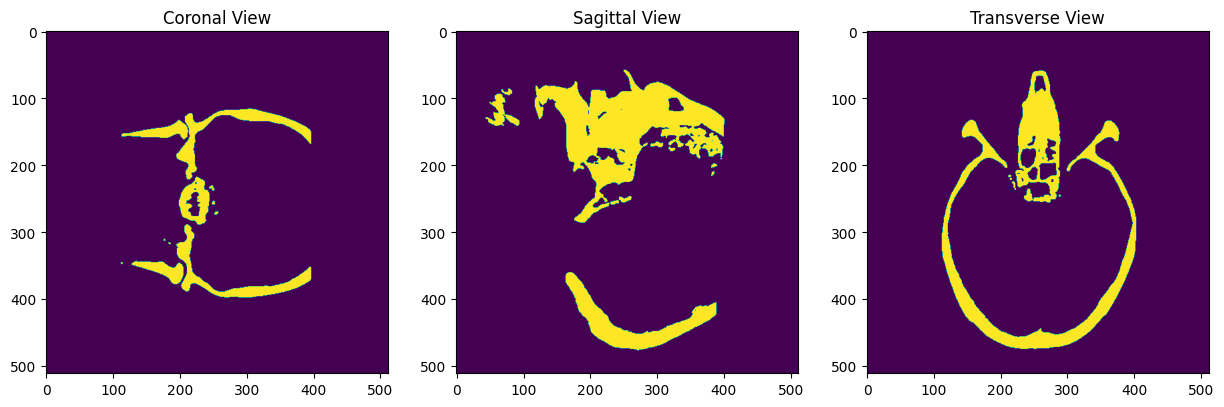

In [5]:
filename = filenames[772]
filepath = os.path.join(dataset_folder, filename)
data, header = nrrd.read(filepath)

# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Coronal view (frontal plane)
axs[0].imshow(data[256, :, :])
axs[0].set_title('Coronal View')

# Sagittal view (saggital plane)
axs[1].imshow(data[:, 256, :])
axs[1].set_title('Sagittal View')

# Transverse view (horizontal plane)
axs[2].imshow(data[:, :, 256])
axs[2].set_title('Transverse View')

# Show the plot
plt.show()


Ho analizzato a mano che la differenza sta nelle qs1 e nelle bad che non sono state giustamente inserite tra i metadati di allenamento.

Ora, come mi  ha suggerito Stefano, clippo i voxels > 1 a 1.

Inoltre mi segno quali sono i bounds minimo e massimo su ogni piano oltre il quale i voxels sono tutti 0. Questo lo faccio per vedere se, croppando porzioni di grid che sono inutili per tutto il dataset, riesco ad ottenere dei parallelepipedi più piccoli dei cubi iniziali, che quindi mi permettono di ridurre il consumo di memoria

In [3]:
coronal_min_bounds = []
coronal_max_bounds = []

saggital_min_bounds = []
saggital_max_bounds = []

transverse_min_bounds = []
transverse_max_bounds = []

In [134]:
counter = 0

for filename in tqdm(filenames):
    # Open file
    filepath = os.path.join(dataset_folder, filename)
    data, header = nrrd.read(filepath)

    # Check presence of voxels != 1 e != 0
    if np.sum(data!= 0) != np.sum(data==1):
        counter += 1
        print(f'Fixing {filename}')
        print(np.sum(data!= 0), np.sum(data==1), np.sum(data<0), np.sum(data>1))
        
        # Clip them to 1
        data = np.where(data > 0, 1, data)
        print(np.sum(data!= 0), np.sum(data==1), np.sum(data<0), np.sum(data>1))
    
        # Save updated grid
        nrrd.write(filepath, data)
    
    # Computing empty space bounds for each plane 
    coronal_plane = np.sum(data, axis=(1,2))
    non_zero_idx = np.nonzero(coronal_plane)[0]
    coronal_min_bounds.append(non_zero_idx[0])
    coronal_max_bounds.append(non_zero_idx[-1])

    saggital_plane = np.sum(data, axis=(0,2))
    non_zero_idx = np.nonzero(saggital_plane)[0]
    saggital_min_bounds.append(non_zero_idx[0])
    saggital_max_bounds.append(non_zero_idx[-1])

    transverse_plane = np.sum(data, axis=(0,1))
    non_zero_idx = np.nonzero(transverse_plane)[0]
    transverse_min_bounds.append(non_zero_idx[0])
    transverse_max_bounds.append(non_zero_idx[-1])
    

100%|██████████| 945/945 [50:22<00:00,  3.20s/it] 


In [135]:
np.save('coronal_min_bounds.npy', coronal_min_bounds)
np.save('saggital_min_bounds.npy', saggital_min_bounds)
np.save('transverse_min_bounds.npy', transverse_min_bounds)

np.save('coronal_max_bounds.npy', coronal_max_bounds)
np.save('saggital_max_bounds.npy', saggital_max_bounds)
np.save('transverse_max_bounds.npy', transverse_max_bounds)

In [6]:
coronal_min_bounds = np.load('coronal_min_bounds.npy')
saggital_min_bounds = np.load('saggital_min_bounds.npy')
transverse_min_bounds = np.load('transverse_min_bounds.npy')
coronal_max_bounds = np.load('coronal_max_bounds.npy')
saggital_max_bounds = np.load('saggital_max_bounds.npy')
transverse_max_bounds = np.load('transverse_max_bounds.npy')

Prendo il minimo dei minimi ed il massimo dei massimi

In [7]:
coronal_min_bound, saggital_min_bound, transverse_min_bound = np.min(coronal_min_bounds), np.min(saggital_min_bounds), np.min(transverse_min_bounds)
coronal_max_bound, saggital_max_bound, transverse_max_bound = np.max(coronal_max_bounds), np.max(saggital_max_bounds), np.max(transverse_max_bounds)

In [8]:
(coronal_min_bound, coronal_max_bound), (saggital_min_bound, saggital_max_bound), (transverse_min_bound, transverse_max_bound)

((7, 490), (91, 511), (0, 506))

Controllo che i bounds siano causati da mesh corrette. Se non lo sono, mi segno la scorrettezza della mesh e ricalcolo il bound senza considerare la mesh scorretta.

In [9]:
np.argsort(saggital_max_bounds)[-2], np.argsort(saggital_min_bounds)[0]

(398, 398)

In [10]:
np.argsort(coronal_max_bounds)[-1], np.argsort(coronal_min_bounds)[1]

(168, 919)

In [11]:
np.argsort(transverse_max_bounds)[-1], np.argsort(transverse_min_bounds)[1]

(590, 885)

In [12]:
filename = filenames[730]
filepath = os.path.join(dataset_folder, filename)
data, header = nrrd.read(filepath)
filename

'CTS381.nrrd'

In [45]:
utils.build_mesh(data, name=filename[:-5], output_folder='../data/mesh-analysis-51mm/', spacing=[0.51, 0.51, 0.51])

TriangleMesh with 1361527 points and 2722384 triangles.


ricalcolo i bounds che erano sbagliati

In [13]:
saggital_max_bound = saggital_max_bounds[np.argsort(saggital_max_bounds)[-2]]
coronal_min_bound = coronal_min_bounds[np.argsort(coronal_min_bounds)[1]]
transverse_min_bound = transverse_min_bounds[np.argsort(transverse_min_bounds)[1]]

In [14]:
(coronal_min_bound, coronal_max_bound), (saggital_min_bound, saggital_max_bound), (transverse_min_bound, transverse_max_bound)

((47, 490), (91, 426), (6, 506))

Il piano trasverso, come ci si aspettava, è quello più esteso.
Voglio fare un crop simmetrico da un lato e dall'altro del piano saggitale, mentre per quanto riguarda il piano coronale non ho questa necessità. Calcolo quanto dev'essere per ogni piano, considerando che il piano più esteso non lo voglio croppare.


In [15]:
bounds_array = np.array([coronal_min_bound, coronal_max_bound, saggital_min_bound, saggital_max_bound, transverse_min_bound, transverse_max_bound], dtype=np.int32)
crops = np.abs(bounds_array - 256) # center around 0 and take absolute value
crops = 256 - crops # compute distance to the border
crops = crops - np.min(bounds_array) # keep the minimal padding already present
crops

array([41, 16, 85, 80,  0,  0])

Dal calcolo viene fuori che nell'asse coronale croppo di 41 all'inizio e di 16 alla fine. Nell'asse saggitale croppo di 80 da entrambi i lati. Voglio che il risultato sia una shape sempre divisibile per due quindi croppo di 40 all'inizio dell'asse coronale


In [25]:
def crop_data(data):
    data = data[40:-16, 80:-80, :]
    return data

data = crop_data(data)
data.shape

(116, 0, 256)

With this voxelization method the grid is rotated with respect to the original position of the skull, and this is visible when the mesh is built again. I want to rotate it in order to have consistency in visualization. I rotate it in the utility function

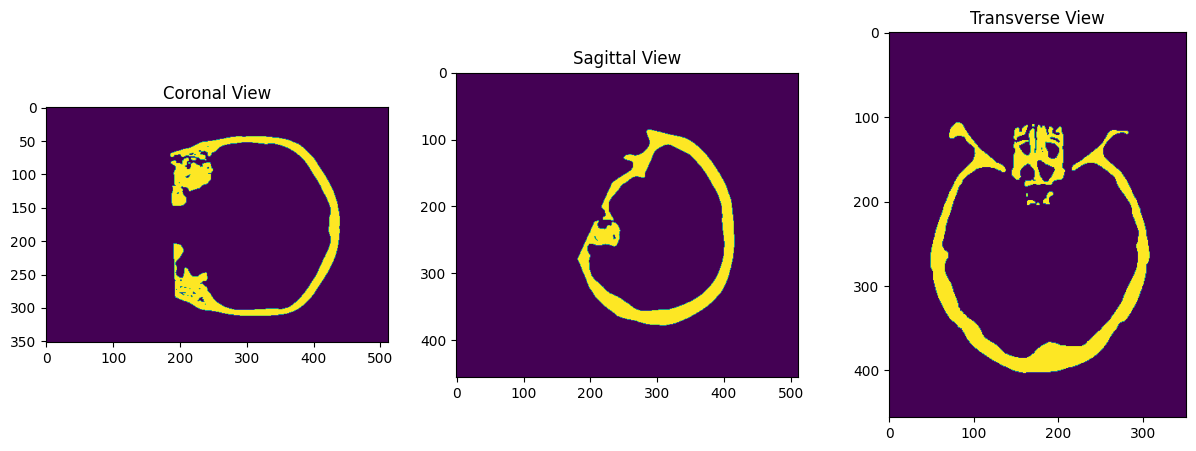

In [17]:
# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Coronal view (frontal plane)
axs[0].imshow(data[256, :, :])
axs[0].set_title('Coronal View')

# Sagittal view (saggital plane)
axs[1].imshow(data[:, 256, :])
axs[1].set_title('Sagittal View')

# Transverse view (horizontal plane)
axs[2].imshow(data[:, :, 256])
axs[2].set_title('Transverse View')

# Show the plot
plt.show()

In [30]:
data_rot = np.rot90(data, k=1, axes=(0,1))
data_rot.shape

(512, 512, 512)

In [32]:
data_rot = np.moveaxis(data_rot, 0, 1)
data_rot.shape

(512, 512, 512)

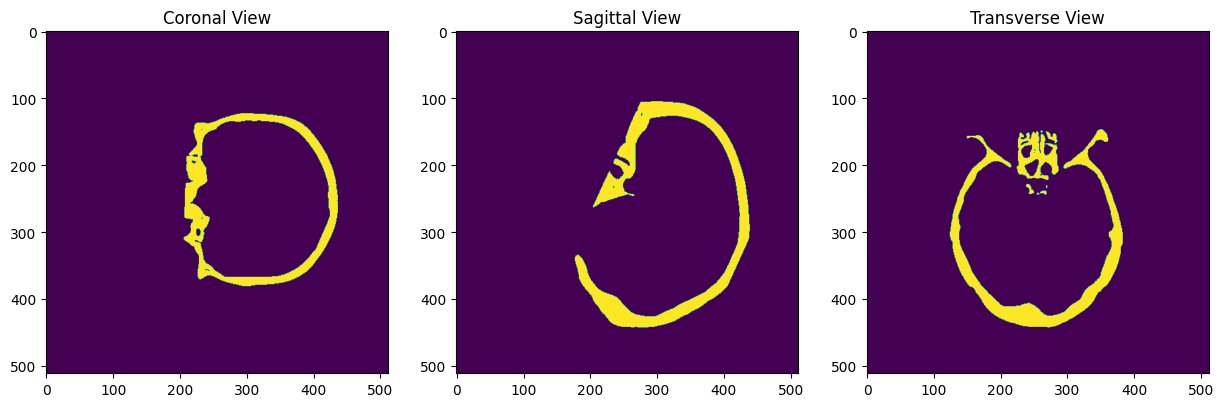

In [33]:
# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Coronal view (frontal plane)
axs[0].imshow(data_rot[256, :, :])
axs[0].set_title('Coronal View')

# Sagittal view (saggital plane)
axs[1].imshow(data_rot[:, 256, :])
axs[1].set_title('Sagittal View')

# Transverse view (horizontal plane)
axs[2].imshow(data_rot[:, :, 256])
axs[2].set_title('Transverse View')

# Show the plot
plt.show()

In [ ]:
utils.build_mesh(data, name=filename[:-5] + 'rotated', output_folder='../data/mesh-analysis-51mm/', spacing=[0.51, 0.51, 0.51])

TriangleMesh with 854970 points and 1709570 triangles.


# Test subsampling methods

In [4]:
dataset_folder = '../data/allcts-051-512-cube'
filenames = [file for file in os.listdir(dataset_folder) if file.endswith('.nrrd')]
filenames[:5]

['CT000.nrrd', 'CT002.nrrd', 'CT003.nrrd', 'CT004.nrrd', 'CT006.nrrd']

In [34]:
filename = filenames[370]
filepath = os.path.join(dataset_folder, filename)
original_image, header = nrrd.read(filepath)
original_image.shape, filename

((512, 512, 512), 'CTS015.nrrd')

In [35]:
original_image = crop_data(original_image)
original_image = np.expand_dims(original_image, axis=0).astype(np.float32)
original_image.shape

(1, 456, 352, 512)

In [29]:
resample_nearest = tio.Resample(2, 'nearest')
resample_linear = tio.Resample(2)

def resample_linear_bin(img):
    img = resample_linear(img)
    img = np.where(img > 0.5, 1, 0)
    return img

In [36]:
image_nearest = np.squeeze(resample_nearest(original_image))
image_linear_bin = np.squeeze(resample_linear_bin(original_image))
squeezed_original_image = np.squeeze(original_image)

squeezed_original_image.shape, image_nearest.shape, image_linear_bin.shape


((456, 352, 512), (228, 176, 256), (228, 176, 256))

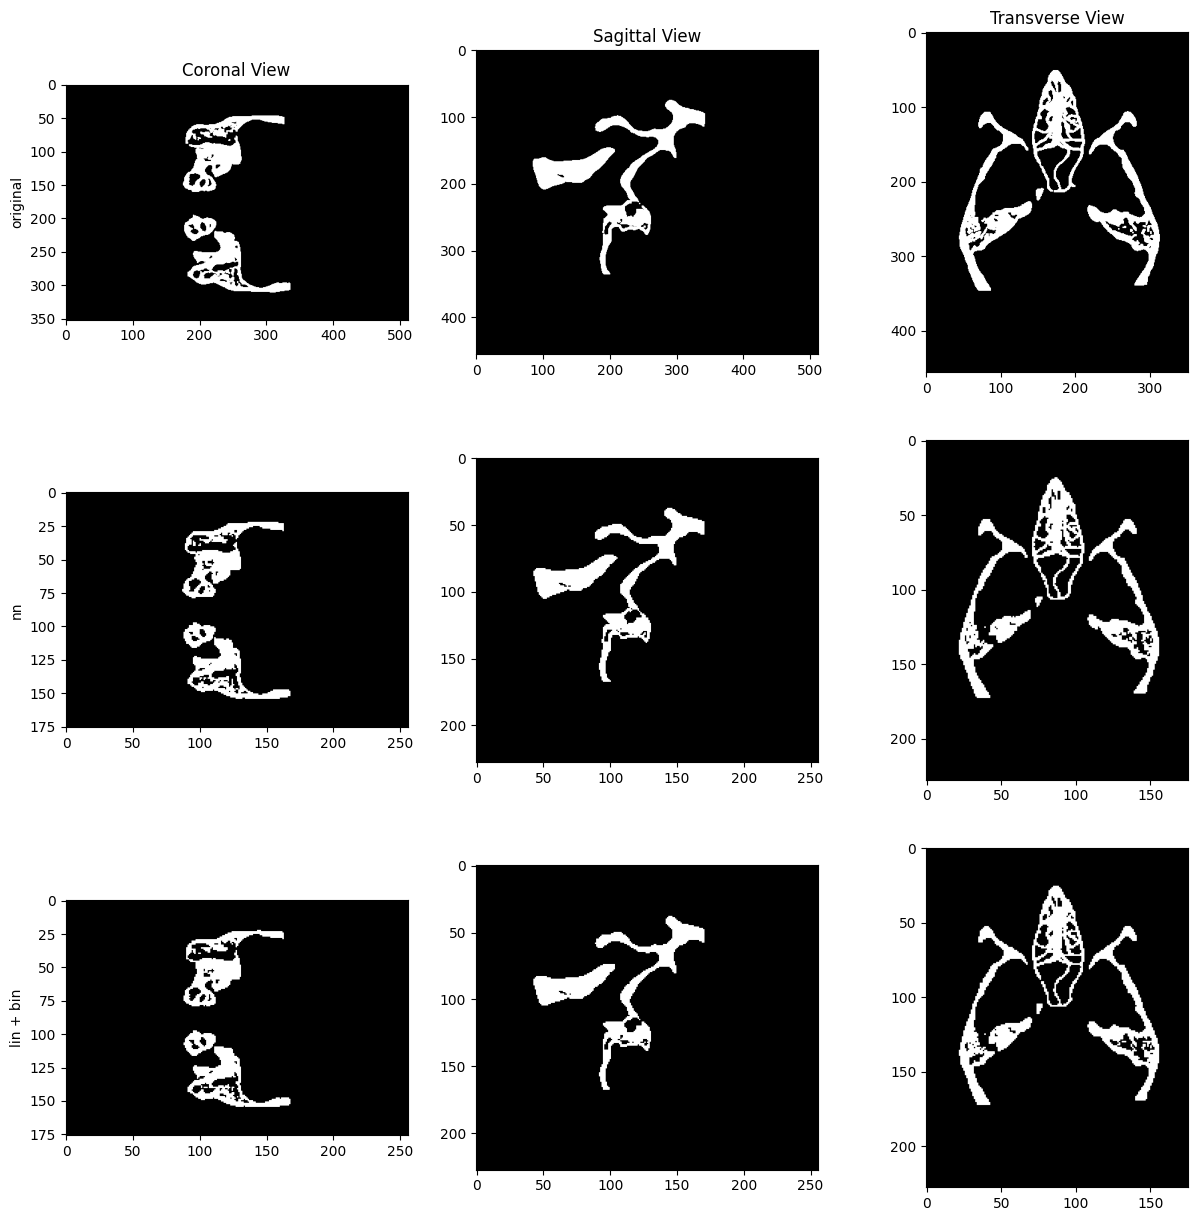

In [37]:
# Plot the middle slice from different perspectives
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].set_title('Coronal View')
axs[0, 1].set_title('Sagittal View')
axs[0, 2].set_title('Transverse View')

axs[0,0].set_ylabel('original')
axs[0, 0].imshow(squeezed_original_image[256, :, :], cmap='Greys_r')
axs[0,1].imshow(squeezed_original_image[:, 256, :], cmap='Greys_r')
axs[0,2].imshow(squeezed_original_image[:, :, 256], cmap='Greys_r')

axs[1,0].set_ylabel('nn')
axs[1, 0].imshow(image_nearest[128, :, :], cmap='Greys_r')
axs[1,1].imshow(image_nearest[:, 128, :], cmap='Greys_r')
axs[1,2].imshow(image_nearest[:, :, 128], cmap='Greys_r')

axs[2,0].set_ylabel('lin + bin')
axs[2, 0].imshow(image_linear_bin[128, :, :], cmap='Greys_r')
axs[2,1].imshow(image_linear_bin[:, 128, :], cmap='Greys_r')
axs[2,2].imshow(image_linear_bin[:, :, 128], cmap='Greys_r')

# Show the plot
plt.show()


Ho deciso di usare linear interpolation + binarization. Mi sembra che mantenga meglio le proprietà anatomiche dei teschi

# Saving cropped subsampled dataset

Ora salvo le immagini croppate. Le salvo a 256, che è la risoluzione a cui le userò.

In [3]:
new_dataset_folder = '../data/allcts-051-256'


In [39]:
for filename in tqdm(filenames):
    # Open file
    filepath = os.path.join(dataset_folder, filename)
    data, header = nrrd.read(filepath)

    data = crop_data(data).astype(np.float32)

    data = np.squeeze(resample_linear_bin(np.expand_dims(data, axis=0)))

    new_filepath = os.path.join(new_dataset_folder, filename)

    # Save updated grid
    nrrd.write(new_filepath, data)

100%|██████████| 945/945 [1:09:57<00:00,  4.44s/it]


Visualizzo le immagini subsampled

In [5]:
dataset_folder = '../data/allcts-051-256'
filenames = [file for file in os.listdir(dataset_folder) if file.endswith('.nrrd')]
filenames[:5]

['CT000.nrrd', 'CT002.nrrd', 'CT003.nrrd', 'CT004.nrrd', 'CT006.nrrd']

In [6]:
filename = filenames[370]
filepath = os.path.join(dataset_folder, filename)
data, header = nrrd.read(filepath)
filename

'CTS015.nrrd'

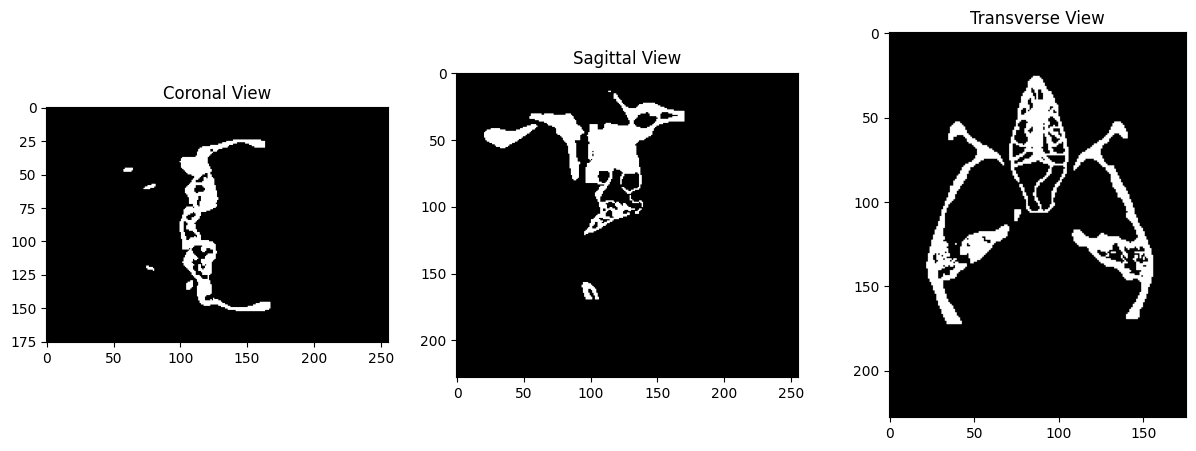

In [7]:
# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

slice_idx = [d//2 for d in data.shape]

# Coronal view (frontal plane)
axs[0].imshow(data[slice_idx[0], :, :], cmap='Greys_r')
axs[0].set_title('Coronal View')

# Sagittal view (saggital plane)
axs[1].imshow(data[:, slice_idx[1], :], cmap='Greys_r')
axs[1].set_title('Sagittal View')

# Transverse view (horizontal plane)
axs[2].imshow(data[:, :, slice_idx[2]], cmap='Greys_r')
axs[2].set_title('Transverse View')

# Show the plot
plt.show()

In [43]:
utils.build_mesh(data, name=filename[:-5] + '-256', output_folder='../data/mesh-analysis-51mm/', spacing=[1.02, 1.02, 1.02])

TriangleMesh with 250276 points and 501200 triangles.


Faccio la mesh anche a 216, per poter confrontare la qualità

In [ ]:
resample = tio.Resample(1.19)
data = resample(np.expand_dims(data, axis=0).astype(np.float32))
data = np.where(data > 0.5, 1, 0)
data = np.squeeze(data)

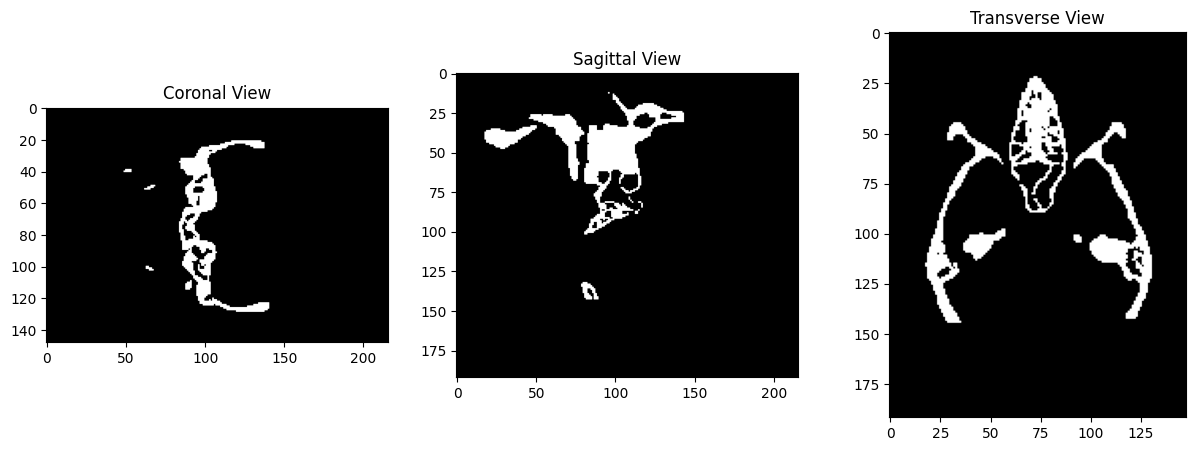

In [24]:
# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

slice_idx = [d//2 for d in data.shape]

# Coronal view (frontal plane)
axs[0].imshow(data[slice_idx[0], :, :], cmap='Greys_r')
axs[0].set_title('Coronal View')

# Sagittal view (saggital plane)
axs[1].imshow(data[:, slice_idx[1], :], cmap='Greys_r')
axs[1].set_title('Sagittal View')

# Transverse view (horizontal plane)
axs[2].imshow(data[:, :, slice_idx[2]], cmap='Greys_r')
axs[2].set_title('Transverse View')

# Show the plot
plt.show()

In [25]:
utils.build_mesh(data, name=filename[:-5] + '-216', output_folder='../data/mesh-analysis-51mm/', spacing=[1.2138, 1.2138, 1.2138])

TriangleMesh with 172104 points and 344820 triangles.


# Visualize images

In [3]:
# p1 = '../data/allcts-global-128/CT016.nrrd'
# p2 = '../data/allcts-vqgan-07/CT016-recon.nrrd'
# p3 = '../data/allcts-vqgan-08/CT016-recon.nrrd'
n1 = 'CTS381-recon'
n2= 'allcts-gen-07-3_176'
p1 = f'../data/allcts-vqgan-07/{n1}.nrrd'
p2 = f'../data/allcts-gen-07/{n2}.nrrd'

In [ ]:
import torchio as tio


def preprocess(p, resample=1, binarize=True):
    resample = tio.Resample(resample)

    img, _ = nrrd.read(p)
    img = torch.from_numpy(img)
    img = torch.squeeze(resample(torch.unsqueeze(img, dim=0).astype(np.float32)))

    if binarize:
        img = (img > 0.5).float()
    
    #  min-max normalized to the range between -1 and 1
    img = (img - img.min()) / (img.max() - img.min()) * 2 - 1
    img = np.rot90(img, axes=(0,2))

    return img

In [5]:

img1 = preprocess(p1)
img2 = preprocess(p2)
# img3 = preprocess(p3)[slice]

In [6]:
slice = 64

<Figure size 640x480 with 0 Axes>

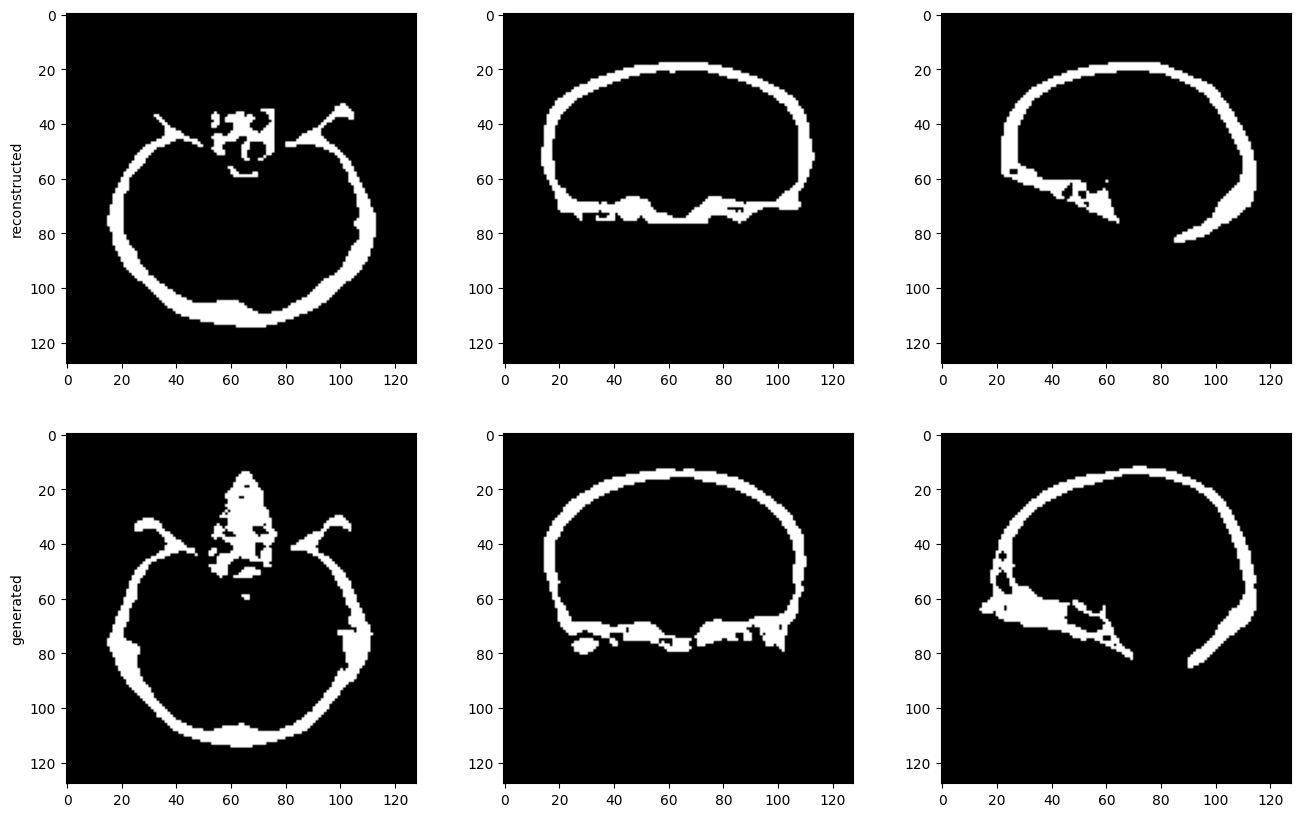

In [7]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,3, figsize=(16, 10)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].imshow(img1[slice], cmap='Greys_r')
axarr[0,0].set_ylabel('reconstructed')
axarr[1,0].imshow(img2[slice], cmap='Greys_r')
axarr[1,0].set_ylabel('generated')
# axarr[2].imshow(img3)
# axarr[2].title.set_text('generated 0.89')
axarr[0,1].imshow(img1[:, slice], cmap='Greys_r')
axarr[1,1].imshow(img2[:, slice], cmap='Greys_r')

axarr[0,2].imshow(img1[:,:,slice], cmap='Greys_r')
axarr[1,2].imshow(img2[:,:,slice], cmap='Greys_r')

In [ ]:
utils.build_mesh(img1, name=n1, output_folder='../data/mesh-most-copies/', spacing=[0.49944812, 0.46262616, 0.3345859])
utils.build_mesh(img2, name=n2, output_folder='../data/mesh-most-copies/', spacing=[0.49944812, 0.46262616, 0.3345859])

TriangleMesh with 73421 points and 146986 triangles.


In [24]:
0.46262616
0.3345859
0.49944812

2097152

## Images at different resolutions, binary and not

In [4]:
def postprocess(img, upsample=0.5, binarize=True):
    upsample = tio.Resample(upsample)
    img= torch.tensor(img.copy())
    img = torch.unsqueeze(img, dim=0)
    img = upsample(img)
    img = torch.squeeze(img)
    # img = torch.squeeze(upsample(torch.unsqueeze(torch.tensor(img), dim=0)))

    if binarize:
        img = (img > 0).float()
    
    return img

In [ ]:
p = '../data/allcts-global-512-other-rot/CT016.nrrd'
img512 = preprocess(p)
img256 = preprocess(p, resample=2)
img256float = preprocess(p, resample=2, binarize=False)
img176 = preprocess(p, resample=2.91)
img128 = preprocess(p, resample=4)
img128float = preprocess(p, resample=4, binarize=False)
img256up = postprocess(img128float)

In [14]:
img128.shape

(176, 176, 176)

<Figure size 640x480 with 0 Axes>

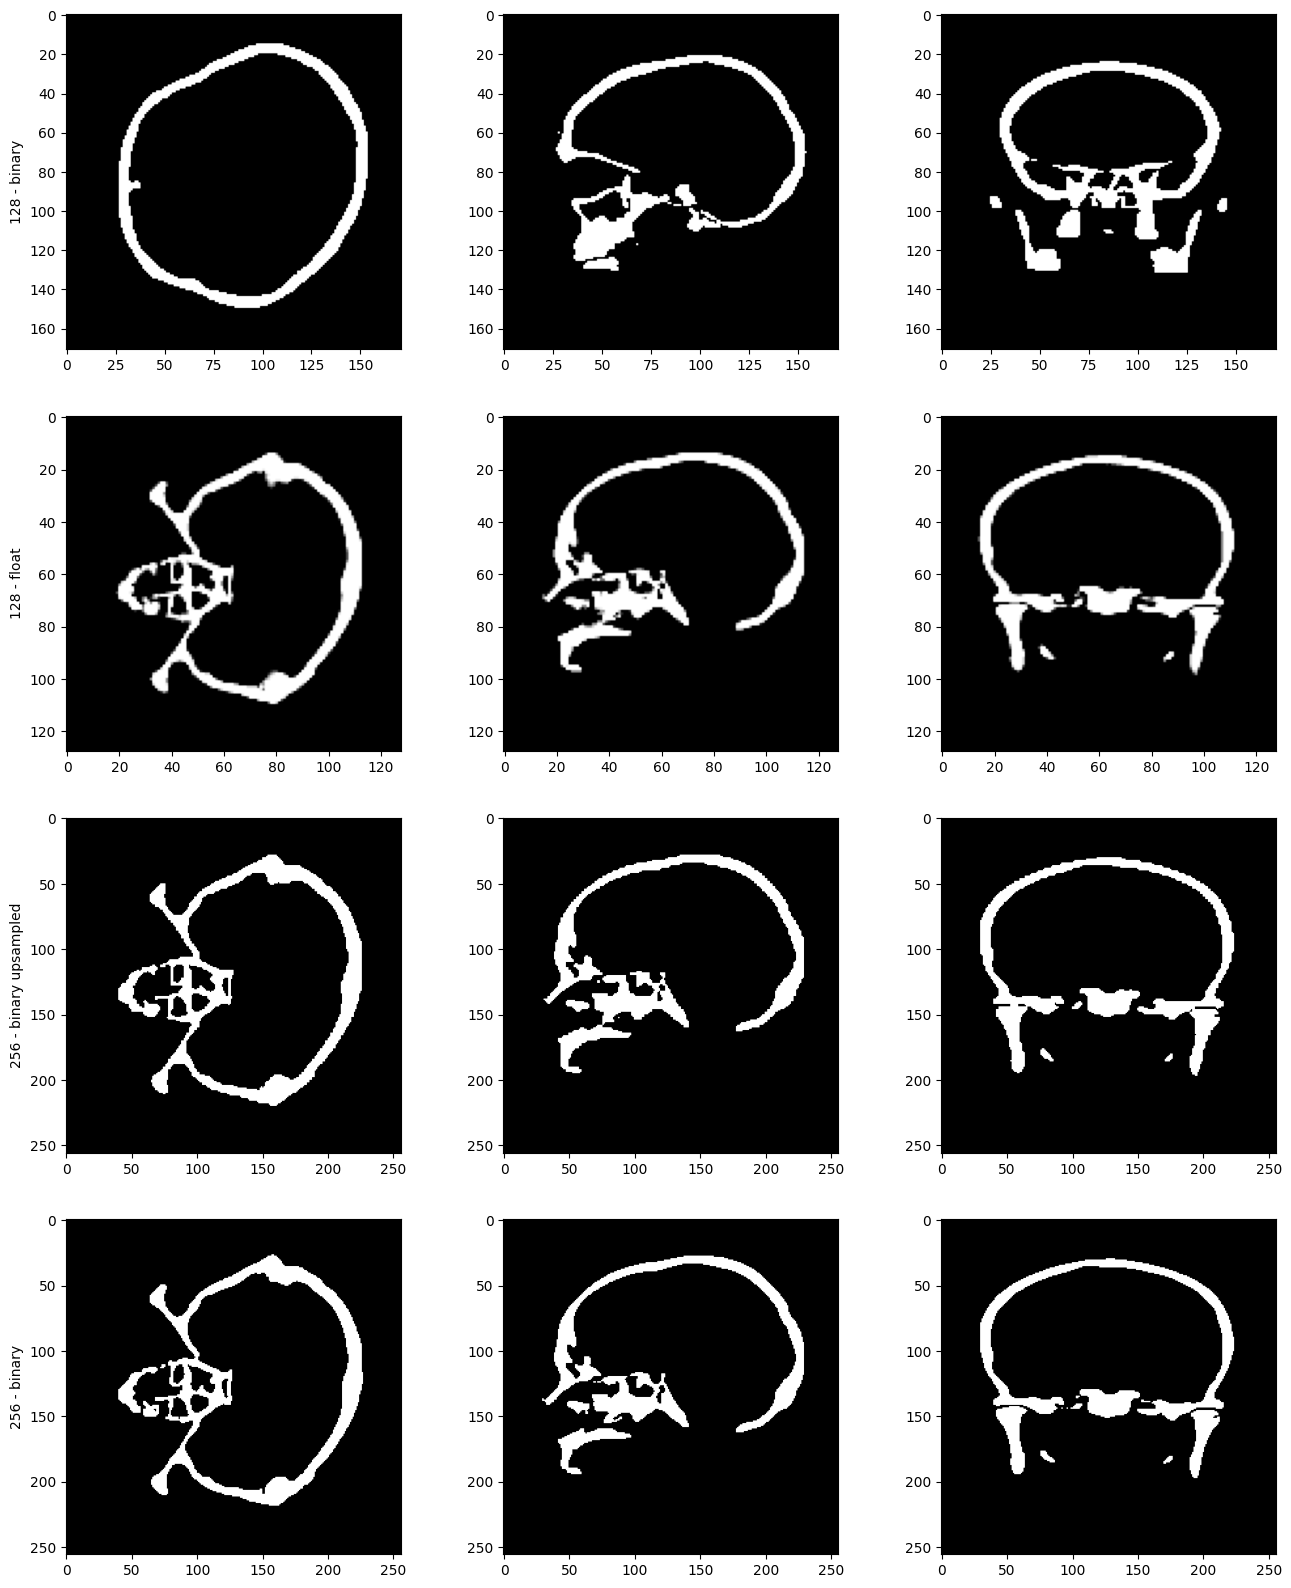

In [6]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,3, figsize=(16, 20)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0,0].set_ylabel('128 - binary')
axarr[0,0].imshow(img128[64], cmap='Greys_r')
axarr[0,1].imshow(img128[:, 64], cmap='Greys_r')
axarr[0,2].imshow(img128[:,:,64], cmap='Greys_r')

axarr[1,0].set_ylabel('128 - float')
axarr[1,0].imshow(img128float[64], cmap='Greys_r')
axarr[1,1].imshow(img128float[:, 64], cmap='Greys_r')
axarr[1,2].imshow(img128float[:,:,64], cmap='Greys_r')

axarr[2,0].set_ylabel('256 - binary upsampled')
axarr[2,0].imshow(img256up[128], cmap='Greys_r')
axarr[2,1].imshow(img256up[:, 128], cmap='Greys_r')
axarr[2,2].imshow(img256up[:,:,128], cmap='Greys_r')


axarr[3,0].set_ylabel('256 - binary')
axarr[3,0].imshow(img256[128], cmap='Greys_r')
axarr[3,1].imshow(img256[:, 128], cmap='Greys_r')
axarr[3,2].imshow(img256[:,:,128], cmap='Greys_r')



## Show a lot of generated images

In [20]:
root_dir = '../data/allcts-lf-07/'
dataset = AllCTsDataset(
    root_dir=root_dir,
    metadata_name='metadata.csv',
    split='all',
    binarize=True,
    qs=[2]
)

In [21]:
# paths =  [f'{root_dir}{name}.nrrd' for name in dataset.df.loc[dataset.df['quality_6'] == 1].name]
paths =  [f'{root_dir}{name}.nrrd' for name in dataset.df.name]

In [22]:
len(paths)

167

In [201]:
from random import shuffle
shuffle(paths)

<Figure size 640x480 with 0 Axes>

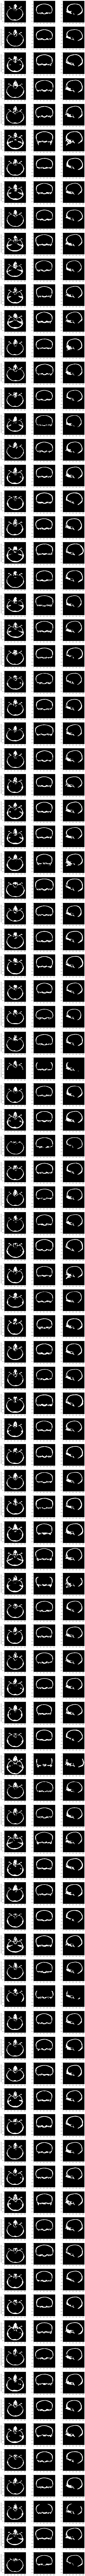

In [23]:
n_max = 100
n = min(n_max, len(paths))
slice = 64

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(n,3, figsize=(16, 5*n)) 

for i, p in enumerate(paths[:n]):
    img = preprocess(p)
    axarr[i,0].set_ylabel(p)
    axarr[i,0].imshow(img[slice], cmap='Greys_r')
    axarr[i,1].imshow(img[:, slice], cmap='Greys_r')
    axarr[i,2].imshow(img[:,:,slice], cmap='Greys_r')
